In [81]:
import spkit as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  
import mne
from copy import deepcopy
from mne.preprocessing import compute_proj_ecg
from mne_connectivity import envelope_correlation
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import random
from mne.preprocessing import ICA, corrmap, create_ecg_epochs, create_eog_epochs
from autoreject import AutoReject
from autoreject import get_rejection_threshold
from autoreject import Ransac

In [82]:
#mne.set_config("MNE_USE_CUDA", True)
#print(mne.get_config("MNE_USE_CUDA"))
print(mne.get_config("MNE_USE_CUDA"))

True


In [83]:
data = np.array(pd.read_csv("D:\Clean Data\IGE\shirband\samples.csv", skiprows=2))
data = np.delete(data, [0, 1, -1, -3, -4], axis=1)

In [84]:
#ch_name = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'A1', 'A2', 'Fz', 'Cz', 'Pz', 'T2', 'T1', 'ECG']
channel_names = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'A1', 'A2', 'Fz', 'Cz', 'Pz', 'ECG']
#ch_name = ['F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'A1', 'A2', 'Fz', 'Cz', 'Pz', 'T2', 'T1']
np.shape(channel_names)

(22,)

In [85]:
#data = data[1000000:1000300]
np.shape(data)

(1815746, 22)

In [86]:
X = deepcopy(data)

In [87]:
sfreq = 300
info = mne.create_info(channel_names, sfreq, ch_types=['eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'ecg'])
raw = mne.io.RawArray(X.T, info)
raw.set_montage('standard_1020')



Creating RawArray with float64 data, n_channels=22, n_times=1815746
    Range : 0 ... 1815745 =      0.000 ...  6052.483 secs
Ready.


<RawArray | 22 x 1815746 (6052.5 s), ~304.8 MB, data loaded>

In [88]:
epochs = mne.make_fixed_length_epochs(raw, duration=10, preload=True)
scaler = mne.decoding.Scaler(info, scalings='mean', with_mean=True, with_std=True)
newx = scaler.fit_transform(epochs.get_data())

Not setting metadata


605 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 605 events and 3000 original time points ...
0 bad epochs dropped


In [89]:
np.moveaxis(newx, 1, 0)
raw = deepcopy(mne.io.RawArray(newx.reshape(22, -1), info))

Creating RawArray with float64 data, n_channels=22, n_times=1815000
    Range : 0 ... 1814999 =      0.000 ...  6049.997 secs
Ready.


In [90]:
filt_raw = raw.copy().filter(l_freq=1.0, h_freq=None)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 991 samples (3.303 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    1.1s finished


Fitting ICA to data using 21 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 11.7s.
Fraction of eeg variance explained by all components: 0.9839901649167587
Creating RawArray with float64 data, n_channels=21, n_times=1815000
    Range : 0 ... 1814999 =      0.000 ...  6049.997 secs
Ready.


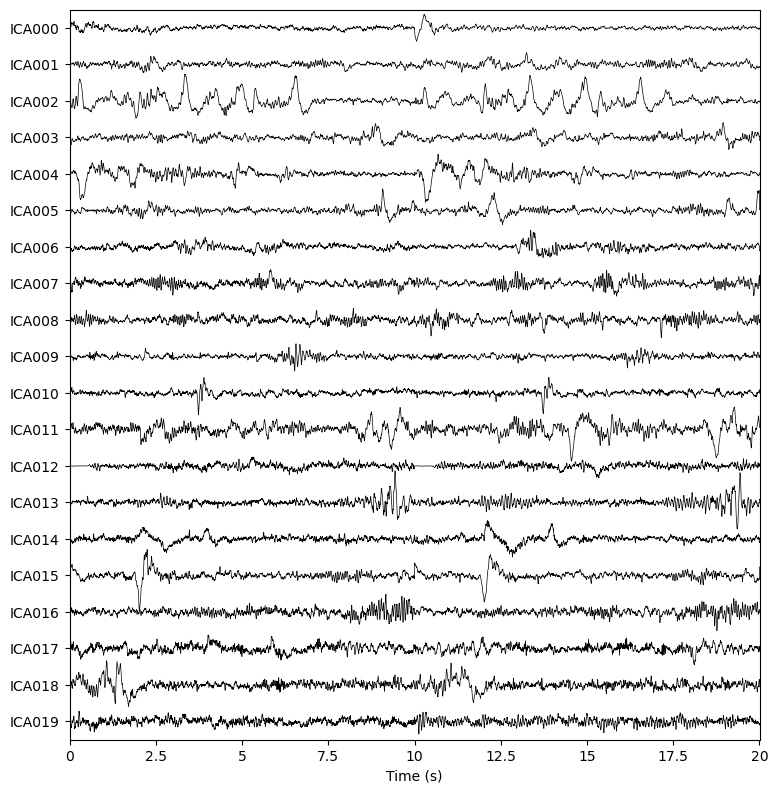

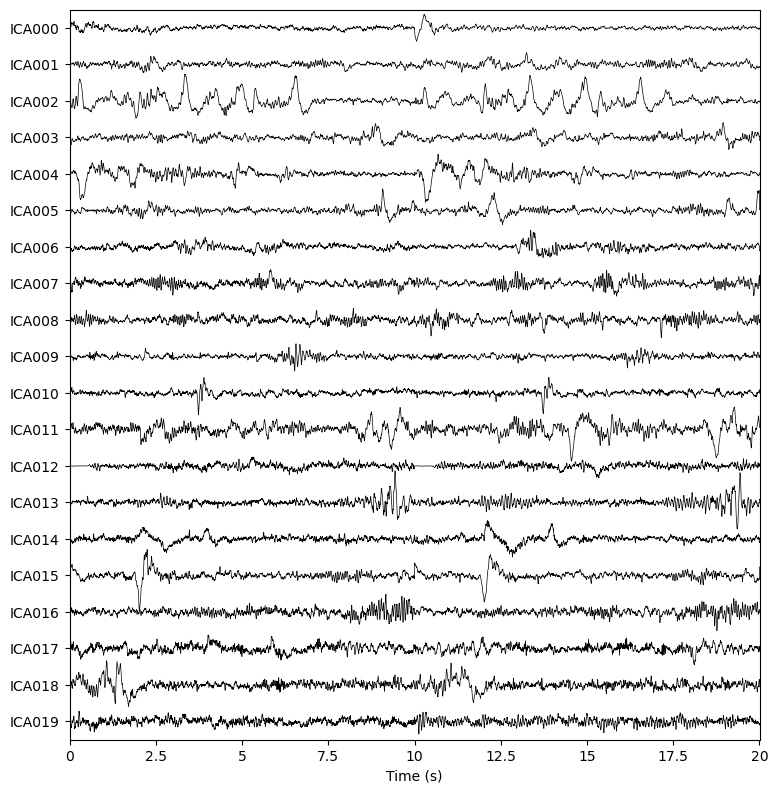

In [80]:
ica = ICA(n_components=20, max_iter="auto", random_state=97, method='fastica')
ica.fit(filt_raw)

explained_var_ratio = ica.get_explained_variance_ratio(filt_raw)
for channel_type, ratio in explained_var_ratio.items():
    print(
        f"Fraction of {channel_type} variance explained by all components: " f"{ratio}"
    )

raw.load_data()
ica.plot_sources(raw, show_scrollbars=False)

In [78]:
rsc = Ransac()

epochs_clean = rsc.fit_transform(epochs)  

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  0%|          | interpolating channels : 0/50 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  0%|          | Iterating epochs : 0/605 [00:00<?,       ?it/s]

[Done]
Interpolating bad channels
    Automatic origin fit: head of radius 95.4 mm
Computing interpolation matrix from 19 sensor positions
Interpolating 2 sensors


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   29.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   29.1s finished


-3350.8992

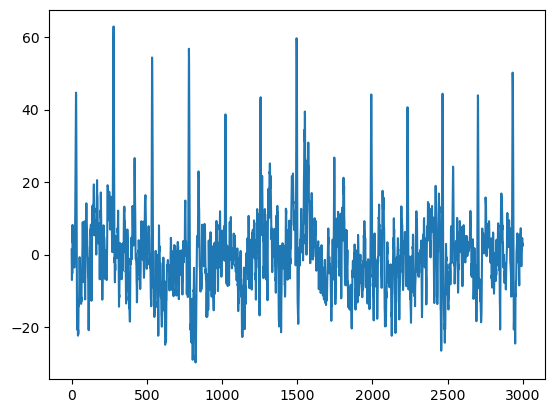

In [91]:
epch = epochs_clean.get_data()
x = np.arange(0, epch.shape[2], 1)
plt.plot(x, epch[1, 16, :])
np.min(epch)